## Top-Down Analysis
- 1: Data extraction and pre-processing
- 2: Create Word2Vec Model
- 3: Find similarities with dictionary
- 4: Scores by environmental discourse

### 1- Data extraction and pre-processing

In [1]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
# from functions import *
import pandas as pd
import nltk
import tqdm
import os

In [2]:
def extract_text_from_pdf(pdf_path):
    """
    Function extract_text_from_pdf
    Returns full text from any pdf by providing pdf_path
    """
    text = ""
    with open(pdf_path, "rb") as file:
        pdf_reader = PyPDF2.PdfReader(file)
        num_pages = pdf_reader.pages

        for page_num in range(len(num_pages)):
            page = pdf_reader.pages[page_num]
            text += page.extract_text()

    return text

def read_from_pdf(files, countries):
    """
    Function read_from_pdf
    Returns a list containing all NECP texts
    """
    texts = []
    for i in tqdm.tqdm(range(len(files)), desc='Reading pdf file'):
        t = extract_text_from_pdf('Energy National Plans/' + files[i])
        texts.append(t)

        txt = open('output/Full_txt/' + countries[i] + ".txt", 'w', encoding="utf-8")
        txt.write(t)
        txt.close()
    
    return texts

def read_by_section(dimension, countries_legend, countries):
    """
    Function read_by_section
    Returns text from a desired section of NECP. 
    countries_legend.xlsx must be filled out before execution, providing which pages should the algorithm read
    """
    texts = []
    for i in range(len(countries)):
        pg_from = int(countries_legend.loc[countries_legend['country'] == countries[i], 'page_from'].iloc[0])
        pg_to   = int(countries_legend.loc[countries_legend['country'] == countries[i], 'page_to'].iloc[0]) + 1  
        text = get_text_from_pdf(countries_legend, countries[i], pg_from, pg_to, dimension, save_txt = False)
        texts.append(text) 

    return texts

def clean_text(text):
    """ 
    Function clean_text
    Returns a sentence without extra-spaces, punctuation signs, etc
    """
    # Normalize tabs and remove newlines
    text = str(text).replace('\t', ' ').replace('\n', '')
    # Remove all characters except A-Z and a dot.
    text = re.sub("[^a-zA-Z\.]", " ", text)
    text = text.replace(".", "")
    # Normalize spaces to 1
    text = re.sub(" +", " ", text)
    # Strip trailing and leading spaces
    text = text.strip()
    # Normalize all charachters to lowercase
    text = text.lower()

    # Filter out words with less than 2 characters
    words = text.split()
    text = [word for word in words if len(word) >= 2]
    text = ' '.join(text)

    return text

def norm_text(text):
    """
    Function norm_text
    Returns words after applying lemmatization
    """
    lemmatizer = WordNetLemmatizer()
    corpus_norm = []
    for i in range(len(text)):
        words = word_tokenize(text[i])
        clean_sent = []
        for j in range(len(words)):
            clean_sent.append(lemmatizer.lemmatize(words[j]))
        corpus_norm.append(' '.join(clean_sent))
    return corpus_norm


#### 1.1- Select which method you want to use to extract the information from NECP. Options:
 - 1: Read a single dimensions from all plans (the name must be indicated in countries_legend tabs)
 - 2: Read all sections of NECPs and store them in folder **output/Full_txt/**
 - 3: If option 2 has been executed previously, just read output stored in folder
 

In [3]:
countries = ['Austria','Belgium','Bulgary','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
'Italy','Latvia','Lithuania','Luxemburg','Malta','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia','Spain','Sweden']

files = [file for file in os.listdir('Energy National Plans/') if file.lower().endswith('.pdf')]

# 1- Read by Dimension
dimension = 'Energy_security_1'
countries_legend = pd.read_excel("countries_legend.xlsx", sheet_name = dimension)
texts = read_by_section(dimension, countries_legend, countries)

# 2- Read from pdf
# texts = read_from_pdf(files, countries)

# 3- Read from txt
# texts = []
# files = os.listdir('output/Full_txt/')
# for file in files:
#     with open('output/Full_txt/' + file, 'r', encoding="utf-8") as f:
#         texts.append(f.read())


Get stop-words in the english language. Next tokenize each text by sentence, while cleaning, normalizing, and tokenizing by word. The output must be a list containing each sentence tokenized by words

In [4]:
stop_words = set(stopwords.words('english'))

data = []
for text in texts:
    sents = sent_tokenize(text)
    sents = [clean_text(sen) for sen in sents]
    sents = [sent for sent in sents if len(word_tokenize(sent)) > 10]
    sents = norm_text(sents)
    
    new_sents = []
    for sent in sents:
        new_sents_1 = []
        for word in word_tokenize(sent):
            new_sents_1.append(word)
        data.append(new_sents_1)


### 2- Create Word2Vec Model

    ### 2.1- Create bigrams and train Word2Vec model

In [5]:
from gensim.models import Word2Vec, phrases
from gensim.models.phrases import Phraser

bigrams = Phraser(phrases.Phrases(data, min_count = 5, threshold = 4))
new_data = list(bigrams[data])

model = Word2Vec(min_count = 1,
                     window=10,       
                     sample=6e-5,     
                     vector_size=300, 
                     alpha=0.03)
model.build_vocab(new_data)
model.train(new_data, total_examples=model.corpus_count, epochs=30, report_delay=1)
# model.save('Word2Vec_general.model') --> FUTURE WORK! 
# adapt code to automatically select a pretrained and prebuild model

    ### 2.2- See how many bigrams we have found

In [6]:
list_of_bigrams = []
for i in list(bigrams[data]):
    for j in i:
        if '_' in j:
            list_of_bigrams.append(j)
list_of_bigrams = list(set(list_of_bigrams))
len(list_of_bigrams)

638

    ### 2.3- Read seed_words Dictionary and find similarities

In [7]:
seed_words = list(pd.read_excel('seed_words_new.xlsx')['X'].values)

new_seed_words = []
for word in seed_words:
    if len(word.split()) > 1:
        new_seed_words.append('_'.join(word.split()))
    else:
        new_seed_words.append(word)
print(len(new_seed_words))

660


In [8]:
def get_word_table(table, key, sim_key='similarity', show_sim = True):
    if show_sim == True:
        return pd.DataFrame(table, columns=[key, sim_key])
    else:
        return pd.DataFrame(table, columns=[key, sim_key])[key]

    ### 2.4- Check output with the most similar words

In [10]:
tables = []
not_found = []
for key in new_seed_words:
    try:
        tables.append(get_word_table(model.wv.similar_by_word(key, topn=80), key, show_sim=True))
    except Exception:
        not_found.append(key)
df = pd.concat(tables, axis=1)
df.to_excel('yes_found.xlsx', index=False)
pd.DataFrame({'not_found': not_found}).to_excel('not_found.xlsx', index=False)
df.head(10)

,idea,similarity,nature,similarity,interaction,similarity,progress,similarity,effort,similarity,...,malicious,similarity,boundary,similarity,exposed,similarity,blackout,similarity,attack,similarity
0,ab,0.999412,energetika,0.999644,http,0.999391,flood,0.999548,towards,0.999695,...,hazard,0.999446,energetika,0.999708,real_time,0.993906,electrical_system,0.999266,computer,0.999692
1,district,0.999394,flood,0.999620,de,0.999374,lt,0.999542,growing,0.999634,...,flood,0.999412,politika,0.999688,flood,0.993901,tsoc,0.999109,against,0.999676
2,ion,0.999382,manual,0.999618,resolution,0.999372,private_sector,0.999541,trend,0.999627,...,lt,0.999398,pdf,0.999665,event,0.993886,restoration,0.999024,resolution,0.999628
3,depot,0.999364,regular,0.999616,which_requires,0.999364,mise,0.999536,local,0.999621,...,energetika,0.999395,caused_by,0.999658,ate,0.993875,recent,0.998947,cyber,0.999626
4,el,0.999362,in_particular,0.999614,assessing,0.999360,energetika,0.999531,con,0.999614,...,adverse,0.999389,ab,0.999656,ef,0.993826,action_plan,0.998884,hazard,0.999586
5,producing,0.999362,politika,0.999612,february,0.999360,tsos,0.999518,mix,0.999606,...,constitutes,0.999387,society,0.999655,declare,0.993822,interrupted,0.998861,http,0.999577
6,caused_by,0.999357,them,0.999611,coordinating,0.999356,such_a,0.999514,decade,0.999605,...,procurement,0.999376,flood,0.999651,application,0.993814,implement,0.998854,de,0.999552
7,enables,0.999354,compensation,0.999611,them,0.999353,exchange,0.999512,nt,0.999604,...,politika,0.999376,education,0.999646,failure,0.993812,burden,0.998847,identify,0.999542
8,energia,0.999354,basic,0.999610,flood,0.999350,education,0.999510,while,0.999600,...,cr,0.999375,inc,0.999645,representation,0.993807,energetickeho,0.998837,which_requires,0.999540
9,ead,0.999354,education,0.999610,hazard,0.999348,each_other,0.999509,higher,0.999597,...,manual,0.999374,burden,0.999643,licence,0.993795,scenario,0.998834,incident,0.999538


### 3- Construct TF-IDF matrix

    ### 3.1- Convert the data into a readable for the TFIDF Vectorizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [12]:
stop_words = set(stopwords.words('english'))

data = []
for text in texts:
    sents = sent_tokenize(text)
    sents = [clean_text(sen) for sen in sents]
    sents = [sent for sent in sents if len(word_tokenize(sent)) > 10]
    sents = norm_text(sents)
    
    new_sents = []
    a = []
    for sent in sents:
        new_sents_1 = []
        for word in word_tokenize(sent):
            if word not in stop_words:
                new_sents_1.append(word)
        a.append(' '.join(new_sents_1))
    data.append(a)

a = []
for i in range(len(data)):
    a.append('. '.join(data[i]))

mixed_corpus = []
for corpus in data:
    mixed_corpus += corpus

    ### 3.2- Create vectorizer model

In [13]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(a)

feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    ### 3.3- Create tfidf matrix with all seed-words

In [14]:
colnames = [e for e in df.columns.to_list() if e != 'similarity']

df_aux = pd.DataFrame(columns = colnames)
for word in colnames:
    df_aux[word] = [0.0]*len(data)

country_names = []
for i in range(len(data)):
    country_names.append(files[i].split(' ')[0])

    tfidf_matrix = vectorizer.fit_transform(data[i])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(np.round(tfidf_matrix.toarray(), 2), columns=feature_names)

    for word in colnames:
        try:
            df_aux.at[i, word] = round(tfidf_df[word].mean(), 3)
        except KeyError:
            df_aux.at[i, word] = 0.0

tfidf_matrix = df_aux
tfidf_matrix.head()

,idea,nature,interaction,progress,effort,perceives,retraining,guidance,agency,indicator,...,stipulated,accidental,geopolitical,calamity,strict,malicious,boundary,exposed,blackout,attack
0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.007,0.0,0.000,0.0
1,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.003,0.000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0
2,0.002,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.006,0.003,...,0.0,0.0,0.0,0.0,0.003,0.0,0.000,0.0,0.000,0.0
3,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0
4,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.015,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.031,0.0


    ### 3.4- Plot results

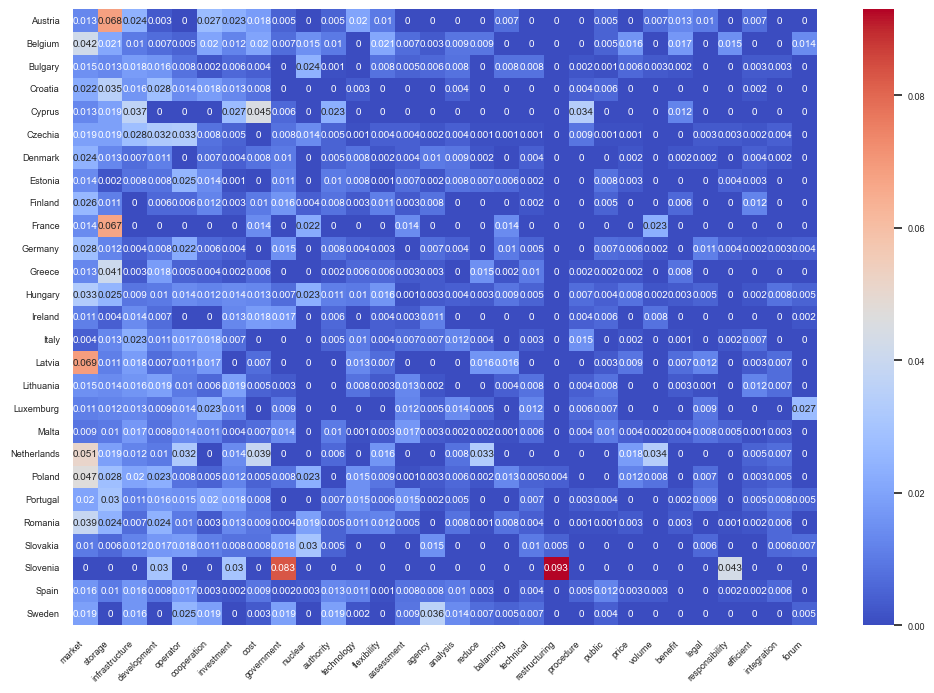

In [15]:
sorted_columns = tfidf_matrix.sum().sort_values(ascending=False).index
bow = tfidf_matrix[sorted_columns[0:100]]
sns.set(font_scale=0.6)
plt.figure(figsize=(12, 8))
sns.heatmap(bow.iloc[:, 0:30], annot=True, cmap='coolwarm', fmt='g', yticklabels=countries)
plt.xticks(rotation=45, ha='right')
plt.show()

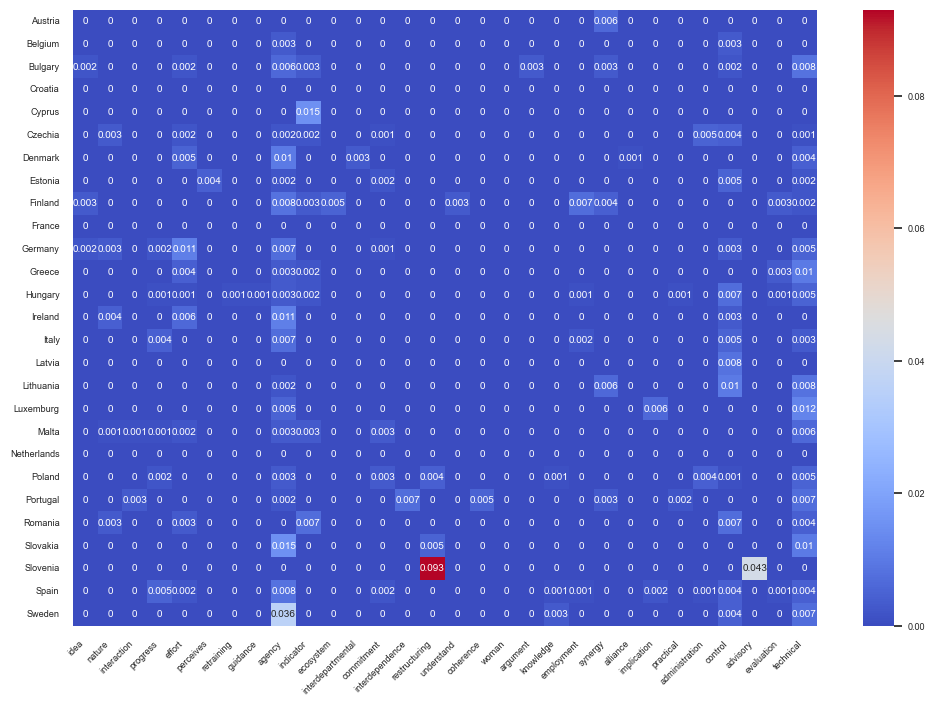

In [16]:
sns.set(font_scale=0.6)
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_matrix.iloc[:, 0:30], annot=True, cmap='coolwarm', fmt='g', yticklabels=countries)
plt.xticks(rotation=45, ha='right')
plt.show()

### 4- Read seed-words dependencies to each environmental discourse

In [17]:
seed_words = pd.read_excel('seed_words_new.xlsx')
set(seed_words['Y'].to_list())

{'adm_rationalism',
 'democr_pragmatism',
 'econom_rationalism',
 'green_radicalism',
 'survivalism',
 'sustainability'}

In [18]:
seed_words = pd.read_excel('seed_words_new.xlsx')

a = list(seed_words[seed_words['Y'] == 'adm_rationalism']['X'].values)
b = list(seed_words[seed_words['Y'] == 'democr_pragmatism']['X'].values)
c = list(seed_words[seed_words['Y'] == 'econom_rationalism']['X'].values)
d = list(seed_words[seed_words['Y'] == 'green_radicalism']['X'].values)
e = list(seed_words[seed_words['Y'] == 'survivalism']['X'].values)
f = list(seed_words[seed_words['Y'] == 'sustainability']['X'].values)

A  = [el for el in a if el in tfidf_matrix.columns.to_list()]
B  = [el for el in b if el in tfidf_matrix.columns.to_list()]
C  = [el for el in c if el in tfidf_matrix.columns.to_list()]
D  = [el for el in d if el in tfidf_matrix.columns.to_list()]
E  = [el for el in e if el in tfidf_matrix.columns.to_list()]
F  = [el for el in f if el in tfidf_matrix.columns.to_list()]


In [19]:
adm_rationalism    = []
democr_pragmatism  = []
econom_rationalism = []
green_radicalism   = []
survivalism        = []
sustainability     = []

for i in range(len(tfidf_matrix)):
    adm_rationalism.append(tfidf_matrix[A].iloc[i].values.mean())
    democr_pragmatism.append(tfidf_matrix[B].iloc[i].values.mean())
    econom_rationalism.append(tfidf_matrix[C].iloc[i].values.mean())
    green_radicalism.append(tfidf_matrix[D].iloc[i].values.mean())
    survivalism.append(tfidf_matrix[E].iloc[i].values.mean())
    sustainability.append(tfidf_matrix[F].iloc[i].values.mean())


percentatges = pd.DataFrame({'country': countries, 'adm_rationalism': adm_rationalism, 'democr_pragmatism': democr_pragmatism, 'econom_rationalism': econom_rationalism,
                             'green_radicalism': green_radicalism, 'survivalism': survivalism, 'sustainability': sustainability})

# percentatges.to_excel('percentatges.xlsx', index=False)
percentatges = percentatges.drop('country', axis = 1)

#### 4.1- Plot results

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

    ### Hierarchical cluster

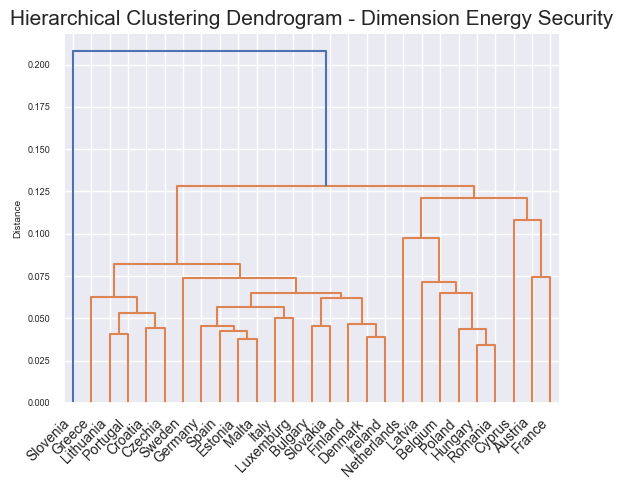

In [21]:
data_scaler = StandardScaler()
similarity_matrix = data_scaler.fit_transform(tfidf_matrix)

Z = linkage(tfidf_matrix, 'ward')
plt.title('Hierarchical Clustering Dendrogram - Dimension Energy Security', fontsize = 15)
plt.ylabel('Distance')
dendrogram(Z, labels=countries)
plt.xticks(rotation=45, ha='right')
plt.show()

    ### Violin plot

C:\Users\adria\AppData\Local\Temp\ipykernel_16092\319230137.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="discourse", y="score", data=new_df, ax=ax, linewidth=.8, inner='point', palette='muted')
C:\Users\adria\AppData\Local\Temp\ipykernel_16092\319230137.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="discourse", y="score", data=new_df, ax=ax, width=0.3, linewidth=.8, palette='bright')


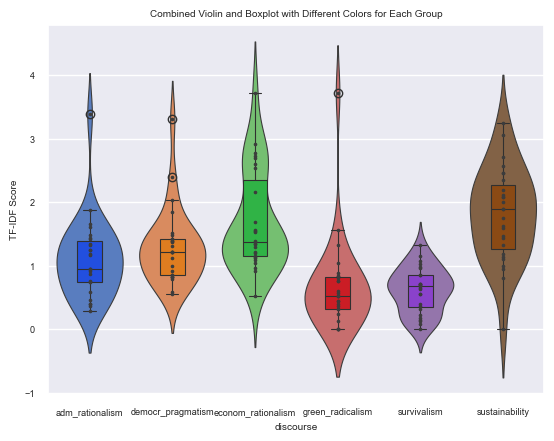

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

scores = perc = percentatges['adm_rationalism'].to_list() + percentatges['democr_pragmatism'].to_list() + percentatges['econom_rationalism'].to_list() + percentatges['green_radicalism'].to_list() + percentatges['survivalism'].to_list() + percentatges['sustainability'].to_list()
scores = [s*1000 for s in scores]
discourses = ['adm_rationalism']*27 + ['democr_pragmatism']*27 + ['econom_rationalism']*27 + ['green_radicalism']*27 + ['survivalism']*27 + ['sustainability']*27

new_df = pd.DataFrame({'country': countries*6, 'discourse': discourses, 'score': scores})

fig, ax = plt.subplots()
palette = sns.color_palette("Set2")
sns.violinplot(x="discourse", y="score", data=new_df, ax=ax, linewidth=.8, inner='point', palette='muted')
sns.boxplot(x="discourse", y="score", data=new_df, ax=ax, width=0.3, linewidth=.8, palette='bright')
ax.set_ylabel("TF-IDF Score")
ax.set_title("Combined Violin and Boxplot with Different Colors for Each Group")
plt.show()

In [24]:
countries

['Austria',
 'Belgium',
 'Bulgary',
 'Croatia',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Ireland',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxemburg',
 'Malta',
 'Netherlands',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden']

In [26]:
percentatges.index = countries
percentatges

,adm_rationalism,democr_pragmatism,econom_rationalism,green_radicalism,survivalism,sustainability
Austria,0.00040,0.003303,0.002596,0.00024,0.000125,0.003243
Belgium,0.00160,0.001424,0.002772,0.00012,0.000643,0.001595
Bulgary,0.00074,0.000848,0.001684,0.00076,0.000679,0.002000
Croatia,0.00036,0.001424,0.001368,0.00000,0.000357,0.002459
Cyprus,0.00058,0.000576,0.002702,0.00060,0.000554,0.001000
Czechia,0.00124,0.000909,0.001544,0.00040,0.000714,0.002081
Denmark,0.00076,0.000848,0.001088,0.00076,0.000321,0.001622
Estonia,0.00148,0.000818,0.001193,0.00032,0.000393,0.001189
Finland,0.00092,0.001212,0.001333,0.00132,0.000554,0.001757
France,0.00028,0.002394,0.001140,0.00000,0.000982,0.000000
